In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
import torch
import model as md
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import tqdm
import torch_intermediate_layer_getter as ilg
from model import MLP

In [2]:
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data.loc[:, ['HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                                     'AveOccup', 'Latitude', 'Longitude']]
Y = pd.concat([california_housing.target, california_housing.data.loc[:, 'MedInc']], axis = 1)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6, random_state=42)
X_calib, X_test, Y_calib, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32)
X_calib = torch.tensor(X_calib.values, dtype=torch.float32)
Y_calib = torch.tensor(Y_calib.values, dtype=torch.float32)

In [4]:
torch.manual_seed(42)
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=64, shuffle=True)
calib_loader = DataLoader(list(zip(X_calib, Y_calib)), batch_size=1, shuffle=True)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=1, shuffle=True)

In [5]:
lol = torch.load("lol.pt", map_location=torch.device('cpu'))
cvae = torch.load("cvae.pt", map_location=torch.device('cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def loss_fn_mse(y, y_hat):
    mse_loss = torch.nn.MSELoss()
    return mse_loss(y, y_hat)

In [7]:
def loss_fn_VAE(recon_feature, og_feature, means, log_var):
    mse_loss = torch.nn.MSELoss()
    mse = mse_loss(recon_feature, og_feature)
    kl_loss = -0.5 * torch.sum(1 + log_var - means.pow(2) - log_var.exp())
    return mse + kl_loss, mse, kl_loss

Pulling the outputs from the penultimate layer with training data

In [8]:
return_layers = {
    'ReLU Layer 2': 'relu1'
}
mid_getter = ilg.IntermediateLayerGetter(lol.mlp, return_layers=return_layers)
mid_output, model_output = mid_getter(X_train.to(device))
# mid_output['relu1'].shape
W_train = mid_output['relu1']
mid_output, model_output = mid_getter(X_test.to(device))
W_test = mid_output['relu1']
train_gen_loader = DataLoader(list(zip(W_train, X_train)), batch_size=64, shuffle=True)
test_gen_loader = DataLoader(list(zip(W_test, X_test)), batch_size=1, shuffle=True)
train_gen_loader = DataLoader(list(zip(W_train, X_train)), batch_size=64, shuffle=True)
test_gen_loader = DataLoader(list(zip(W_test, X_test)), batch_size=1, shuffle=True)

In [9]:
def get_score_quantile(alpha, model, calib_loader):
    model.eval()
    with torch.no_grad():
        i = 0
        losses = []
        for data, target in calib_loader:
            data = data.to(device)
            target = target.to(device)
            i = i + 1
            Y_hat = model(data)
            loss = loss_fn_mse(Y_hat, target).cpu().numpy()
            losses.append(loss)
    N_c = len(calib_loader)
    return np.quantile(losses, (N_c + 1)*(1 - alpha)/N_c), np.sort(losses)

In [10]:
def get_variance_estimate(gen_model, model, calib_loader):
    gen_model.eval()
    with torch.no_grad():
        i = 0
        losses = np.zeros(64)
        for data, target in calib_loader:
            data = data.to(device)
            target = target.to(device)
            i = i + 1
            Z_hat = gen_model.generate(data, 1)
            Z = model.mlp[:-1](data)
            mse_loss = torch.nn.MSELoss(reduction='none')
            loss = torch.square(Z_hat - Z)
            losses = np.vstack((losses, loss.cpu().numpy()))
    return torch.tensor(np.sqrt(np.mean(losses[1:], axis = 0)), dtype = torch.float32)
    

In [11]:
score_quantile, loss = get_score_quantile(0.1, lol, calib_loader)
print(score_quantile)
print(loss)
print(torch.max(Y_train, dim = 0))

4.2456299046444315
[1.0132830e-04 1.4882859e-04 1.9944391e-04 ... 3.4837112e+01 3.8332645e+01
 4.4323589e+01]
torch.return_types.max(
values=tensor([ 5.0000, 15.0001]),
indices=tensor([ 17, 167]))


In [14]:
variance_est = get_variance_estimate(cvae, lol, calib_loader)
print(variance_est)

tensor([4.0588e-01, 2.1550e-11, 1.3709e-06, 1.8022e-06, 2.4851e-08, 1.1842e-11,
        7.6117e-08, 8.8395e-10, 2.1051e-07, 2.8829e-03, 2.3028e-07, 1.0015e-02,
        1.1304e-07, 2.8556e-02, 1.4516e-05, 1.6762e-07, 3.2316e-06, 1.7820e-01,
        3.6104e-10, 2.8217e-06, 3.2833e-02, 3.7770e-02, 1.4878e-01, 9.3465e-06,
        3.0404e-12, 1.3564e-07, 2.6625e-06, 3.8964e-07, 1.0216e-07, 1.4123e-06,
        6.1923e-02, 1.2295e-01, 1.6365e-08, 1.9601e-03, 5.1452e-05, 2.7477e-01,
        6.4172e-02, 1.3776e-07, 3.3312e-11, 5.7348e-07, 2.4887e-05, 6.5400e-02,
        2.8678e-08, 2.9075e-05, 1.1028e-08, 1.5752e-01, 2.3118e-01, 5.2157e-09,
        1.2026e-10, 2.1276e-02, 4.4333e-13, 1.4284e-03, 1.9393e-09, 4.2001e-05,
        1.5826e-01, 1.4007e-12, 1.0123e-06, 4.1828e-08, 6.0682e-07, 2.4902e-01,
        1.7811e-09, 9.9891e-08, 2.9174e-10, 5.0334e-03])


In [12]:
def pp_csi(quantile, gen_model, point_estimator, n_samples, data, layer, var_est):
    gen_model.eval()
    point_estimator.eval()
    y_hat = point_estimator(data.reshape(1, -1))
    regen_w = gen_model.generate(data.reshape(1, -1), n_samples)
    noise = torch.randn(n_samples, regen_w.shape[1])
    regen_z = regen_w + noise * var_est.repeat(n_samples, 1)
    regen_y = layer(regen_z)
    # regen_y = point_estimator(regen_w)
    prediction_set = y_hat.detach().numpy().reshape(1, -1)
    for i in range(n_samples):
        if loss_fn_mse(regen_y[i], y_hat) <= quantile:
            prediction_set = np.vstack((prediction_set, regen_y[i].detach().numpy().reshape(1, -1)))
    return prediction_set


In [15]:
# print(X_test[0].reshape(1, 7))
predictionset= pp_csi(score_quantile, cvae, lol, 200, X_test[0], lol.mlp[-1], variance_est)
# print(Y_train[0])
# print(predictionset)
# print(regen_w[0])
# print(lol.mlp[:-1](X_train[0].unsqueeze(0)))
# print(loss_fn_mse(regen_w[0], lol.mlp[:-1](X_train[0].unsqueeze(0))))
# print(loss_fn_mse(lol(X_train[0].unsqueeze(0)), lol.mlp[-1](regen_w[0])))
print(len(predictionset))

201


/home/srayan/miniconda3/envs/.conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Wow um this is trash and this is proof that something is sus

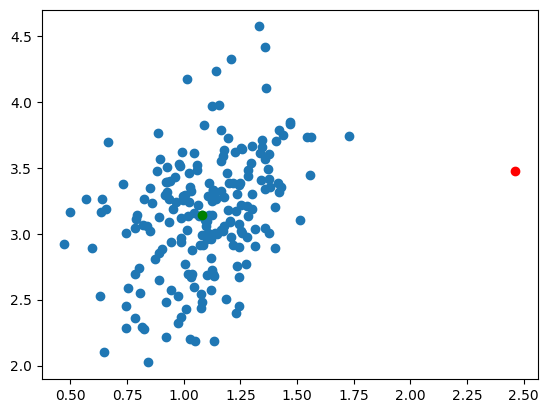

In [16]:
plot_x = predictionset[:, 0]
# plot_x = regen_y
plot_y = predictionset[:, 1]
plt.scatter(plot_x, plot_y)
plt.scatter(Y_test[0, 0].detach().numpy(), Y_test[0, 1].detach().numpy(), color = 'red')
plt.scatter(predictionset[0, 0], predictionset[0, 1], color = 'green')


In [17]:
def make_10_scatterplots(data, score_quantile, gen_model, point_estimator, layer, variance_est, n_samples, true_y):
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(10):
        pred_set = pp_csi(score_quantile, gen_model, point_estimator, n_samples, data[i], layer, variance_est)
        plot_x = pred_set[:, 0]
        plot_y = pred_set[:, 1]
        ax[i//5, i%5].scatter(plot_x, plot_y)
        ax[i//5, i%5].scatter(true_y[i, 0].detach().numpy(), true_y[i, 1].detach().numpy(), color = 'red')
        ax[i//5, i%5].scatter(pred_set[0, 0], pred_set[0, 1], color = 'green')
    plt.show()


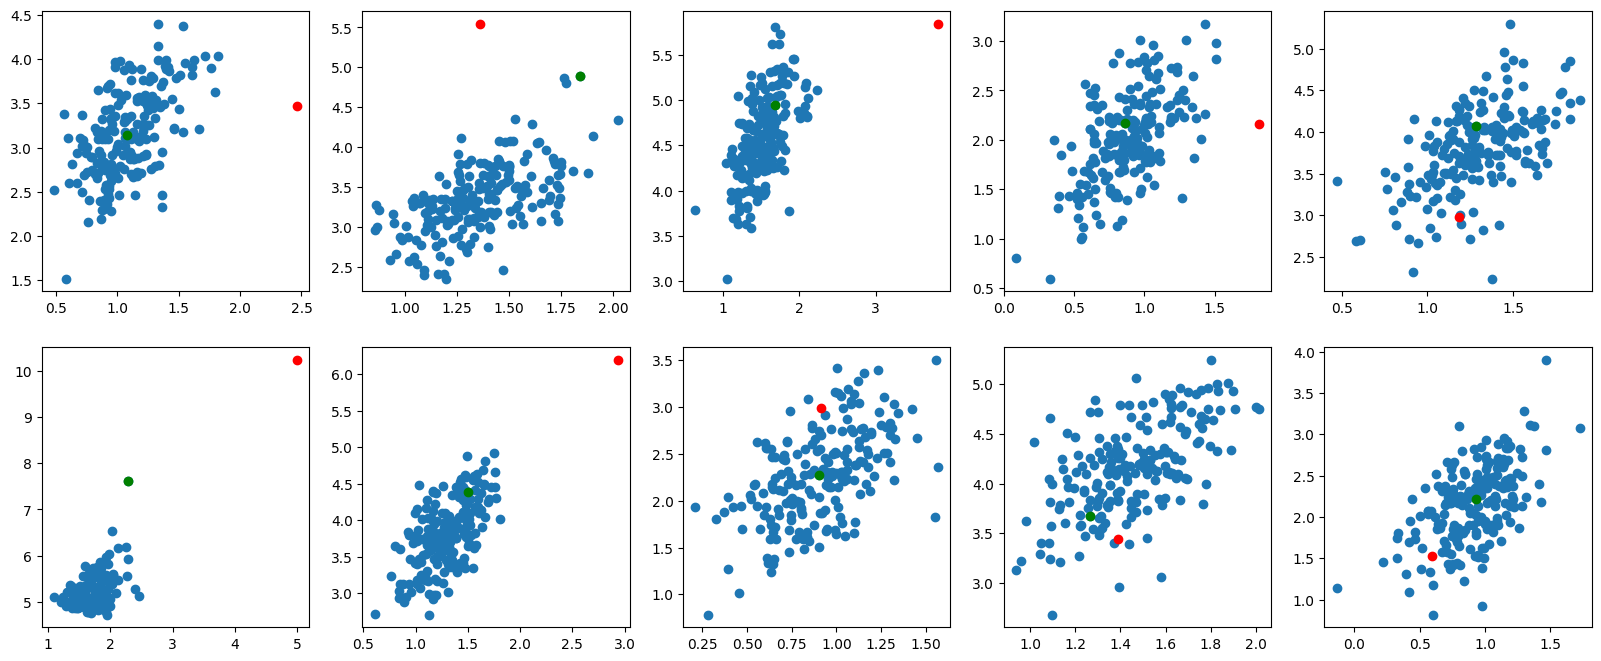

In [18]:
make_10_scatterplots(X_test[:10], score_quantile, cvae, lol, lol.mlp[-1], variance_est, 200, Y_test[:10])